# **20230622**

## 19장 GAN, 오토 인코더

- GAN : 없는 것을 만들어냄
- 오토 인코더 : 특징 추출


### **GAN**(Generative Adversarial Networks) : 생성적 **적대** 신경망

                생성(신경망) <----적대----> 판별(신경망)

- 임의로 생성한 것(가짜)을 판별하지 못할 때까지(중간(0.5)에 올 때까지) 학습

- GAN은 딥러닝의 원리를 활용해 가상 데이터를 생성하는 알고리즘(이미지, 문장, 금융데이터,...)



1. 입력 2. 생성자 3. 판별자 4. 판단


### 01 가짜 제조 공장 , **생성자**(generator)


- **생성자** 에서는 optimizer를 사용하는 최적화 과정, 컴파일 과정 없음

- 판별자에서 오차 나옴 -> 여기서 optimizer, compile


- 이미지 생성 시 CNN을 사용함 -> 이미지 크기 축소될 수 있음 -> 원본 이미지와 같은 크기로 만들기위해 maxpooling 사용하지 않고 padding 사용

- **배치 정규화(Batch Normalization)**: 입력 데이터의 평균이 0, 분산이 1이되도록 재배치 <br> => 층에서 층으로 넘어갈때(입력층의 입력데이터는 데이터 전처리를 통해 따로 정규화함)


- 생성자 activation func : 'relu'
- 출력층 activation func : 'tanh' (-1~1)



### 02 진위를 가려내는 장치 , **판별자**(discriminator)


- 얼마나 가짜인지 판별

- CNN 구조와 동일

- **판별만 함 => 학습 기능 꼭 꺼두기**


- 판별자는 진짜, 가짜 둘 다 학습
    - 진짜는 학습할 수록 1에서 0.5에 가까워짐
    - 가짜는 학습할 수록 0에서 0.5에 가까워짐

### 03 적대적 신경망 실행하기

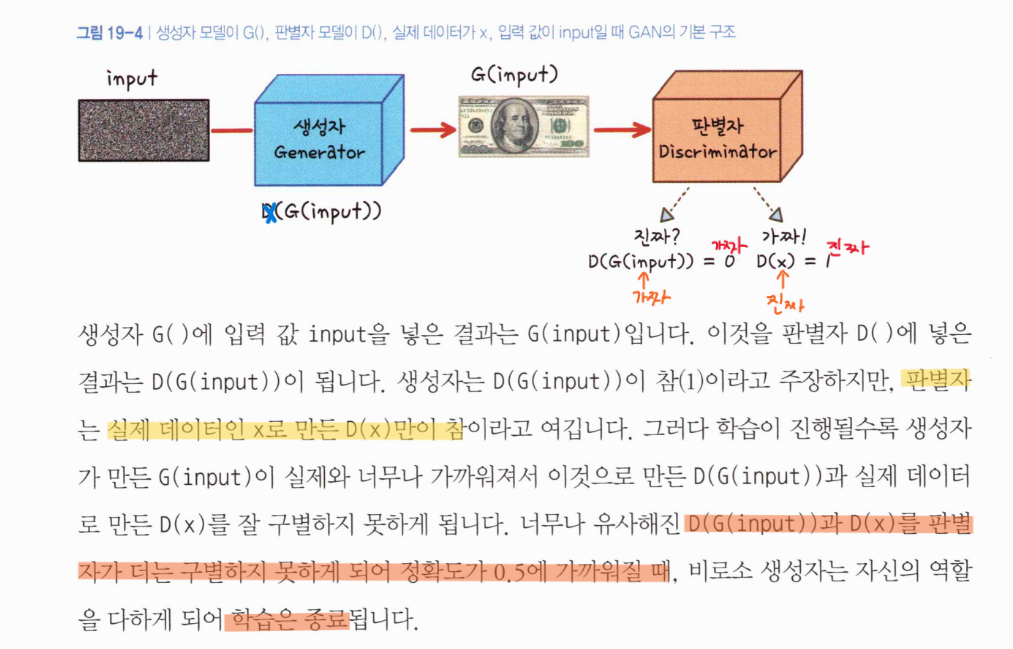

In [31]:
from IPython.display import Image
Image('./ch19_gan.png')

In [21]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

- mnist 데이터셋 : 28*28 손글씨 이미지 데이터

: 7*7 로 시작해서 ***UpSampling2D*** 두번 거쳐 28\*28로 늘려 출력

In [23]:
# 생성자 모델

# 순차적으로 신경망 구성 -> 순차적 학습
generator = Sequential()

# 입력층
# (노드 수*진짜 이미지 크기(n*n), 입력데이터(random), relu) output: 1차원 128*7*7개 노드
generator.add(Dense(128* 7*7, input_dim=100, activation=LeakyReLU(0.2)))
# 128*7*7 = 6272

# 정규화(평균0, 분산1)
generator.add(BatchNormalization())

# 1차원(6272*1) -> 3차원(7,7,128)
generator.add(Reshape((7,7,128)))

# (7,7,128) --이미지 2배 확장--> (14,14,128) : 확장시 유사한 값으로 늘림
generator.add(UpSampling2D())

# CNN학습 output : 14*14*64 이미지
generator.add(Conv2D(64, kernel_size=5, padding='same'))

# 정규화
generator.add(BatchNormalization())

# 활성함수 relu                   기울기 부여(0이하 음수값 나옴)
generator.add(Activation(LeakyReLU(0.2)))

# (14,14,64) --이미지 2배 확장--> (28,28,64)
generator.add(UpSampling2D())

# 출력층 
# output: 28*28 *1개 가짜 이미지(-1~1 데이터 가짐)
generator.add(Conv2D(1, kernel_size=5, padding='same',activation='tanh'))

generator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization_8 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_8 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_9 (Batc  (None, 14, 14, 64)      

In [24]:
# 판별자 모델

discriminator = Sequential()

# 학습기능 o                        
# strides=2 : 가짜이미지 판별~ 꼼꼼하게 안봐도됨
discriminator.add(Conv2D(64, kernel_size=5, strides=2,
                         input_shape=(28,28,1), padding='same'))

discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))

# 학습기능 o
discriminator.add(Conv2D(128, kernel_size=5, strides=2,
                         padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())

# 학습기능 o
# 이미지 1개 출력
discriminator.add(Dense(1,activation='sigmoid'))

discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 activation_7 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 activation_8 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [25]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# 학습 기능 꺼두기
discriminator.trainable = False

In [26]:
# 생성자와 판별자 모델 연결 시키는 gan 모델 만들기

# 입력 차원 100개 = 생성자의 입력층 입력데이터=100개로 설정되어있음
ginput = Input(shape=(100,))

# 합성함수 형태 : f(f(f()))
dis_output = discriminator(generator(ginput)) # output(sigmoid): 0~1

# 신경망들 연결 : 함수형 신경망
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_7 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_8 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


- 함수형 신경망은 순차적 실행이 아닌 순서를 바꿔 실행할 수 있음


- 신경망
    - sequential
    - functional
    - subclass(상속)

In [29]:
def gan_train(epoch, batch_size,saving_interval):

    # 진짜 데이터 불러오기
    (X_train,_),(_,_) = mnist.load_data()

    # X_train.shape : (60000, 28, 28)
    X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')

    # 정규화
    # 가짜 이미지: -1~1 사이 값 ~ 진짜 이미지(0~255) 정규화 필요
    X_train = (X_train - 127.5) / 127.5

    # 진짜 이미지 label=1
    real = np.ones((batch_size,1))
    # 가짜 이미지 label=0
    fake = np.zeros((batch_size,1))

    for i in range(epoch):

        # 실제 데이터 판별자에 입력
        idx = np.random.randint(0, X_train.shape[0], batch_size) # 0~6만개 중 32개 random 추출
        imgs = X_train[idx] # 실제 이미지 32개

        # train_on_batch : batch만큼(32번) '한번만' 학습 = 한번 역전파 = output: 오차 1개
        #                                       (진짜 이미지, 답)
        d_loss_real = discriminator.train_on_batch(imgs, real) # 진짜의 오차 1~0.5


        # 가짜 이미지를 판별자에 입력
        # noise=가짜 데이터 생성 100개짜리 32개 
        noise = np.random.normal(0,1,(batch_size,100))  # normal(평균, 분산, 개수)
        gen_imgs = generator.predict(noise) # output: 가짜 이미지
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # 가짜의 오차 0~0.5



        # 판별자-생성자 오차 계산
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # 각 오차의 평균
        #           한번 학습(가짜데이터, 진짜 이미지)-> 이미학습이 끝난 상황으로 큰 의미 없음
        g_loss = gan.train_on_batch(noise, real)

        print('epoch: %d'%i , 'd_loss : %.4f'%d_loss,'g_loss: %.4f'%g_loss)



        #####################################################################

        # 중간 과정 이미지 저장
        if i % saving_interval ==0:
            noise = np.random.normal(0,1, (25,100))
            gen_imgs = generator.predict(noise)

            # rescale images 0~1
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5,5)
            count=0
            for j in range(5):
                for k in range(5):
                    axs[j,k].imshow(gen_imgs[count,:,:,0],cmap='gray')
                    axs[j,k].axis('off')
                    count += 1
            # fig.savefig('../data/gan_images/gan_mnist_%d.png'%i)


1/1 [==============================] - 0s 43ms/step
epoch: 0 d_loss : 0.5541 g_loss: 0.2770
1/1 [==============================] - 0s 46ms/step
epoch: 1 d_loss : 0.5756 g_loss: 0.1522
1/1 [==============================] - 0s 40ms/step
epoch: 2 d_loss : 0.5647 g_loss: 0.1880
1/1 [==============================] - 0s 33ms/step
epoch: 3 d_loss : 0.5097 g_loss: 0.3387
1/1 [==============================] - 0s 36ms/step
epoch: 4 d_loss : 0.4321 g_loss: 0.6136
1/1 [==============================] - 0s 36ms/step
epoch: 5 d_loss : 0.4124 g_loss: 0.8862
1/1 [==============================] - 0s 40ms/step
epoch: 6 d_loss : 0.3822 g_loss: 1.1029
1/1 [==============================] - 0s 44ms/step
epoch: 7 d_loss : 0.3189 g_loss: 1.1463
1/1 [==============================] - 0s 35ms/step
epoch: 8 d_loss : 0.3436 g_loss: 0.9445
1/1 [==============================] - 0s 40ms/step
epoch: 9 d_loss : 0.3899 g_loss: 0.6938
1/1 [==============================] - 0s 37ms/step
epoch: 10 d_loss : 0.6966 g_

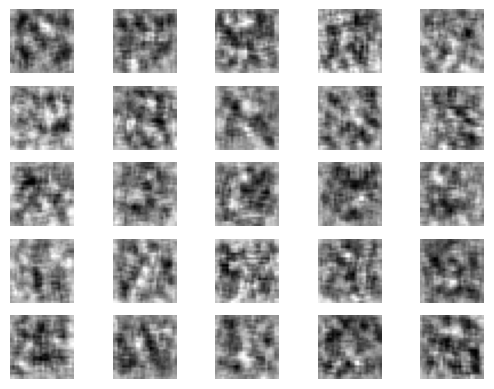

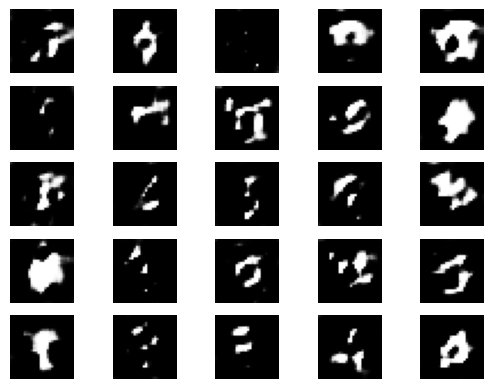

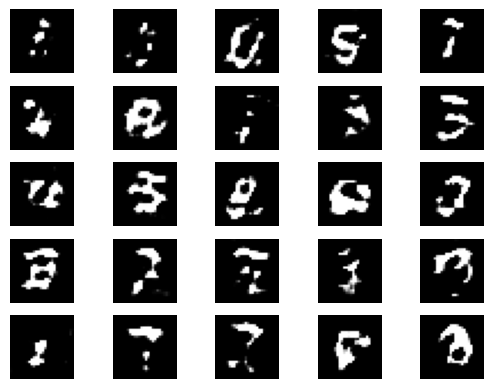

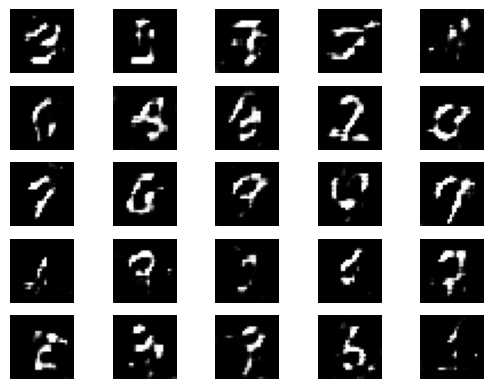

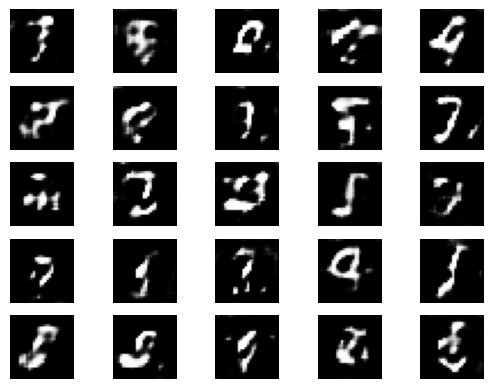

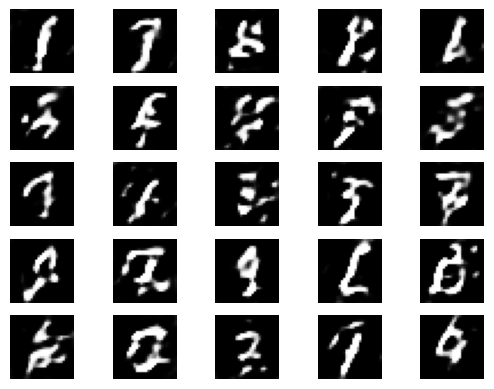

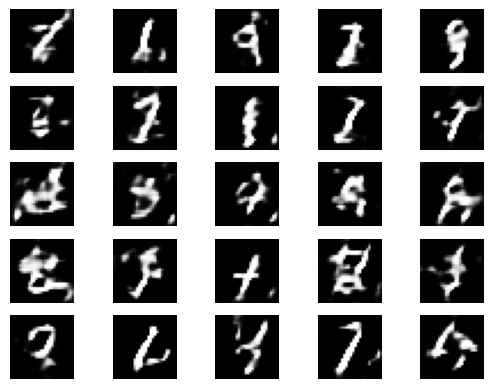

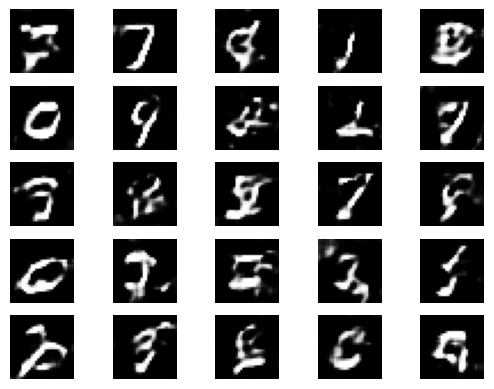

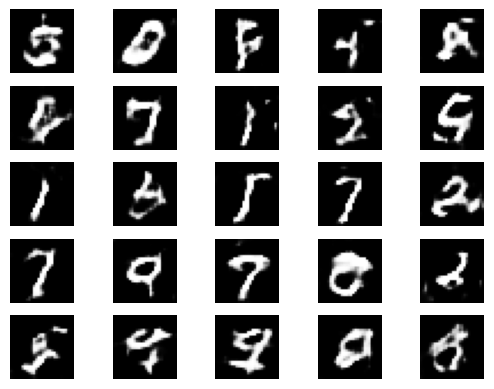

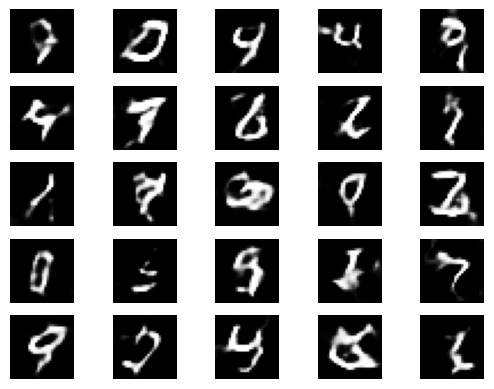

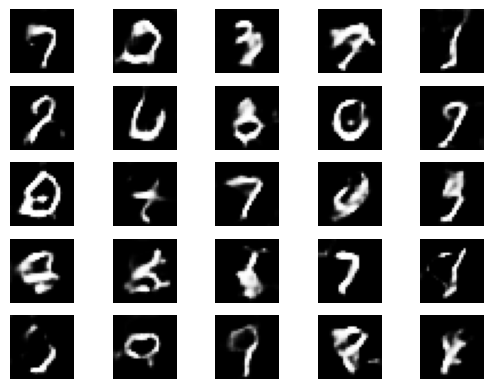

In [30]:
# 반복횟수:2000, 32개 이미지씩 가져옴
# 200 epoch 마다 생성(학습)된 가짜 이미지 저장
gan_train(2001,32, 200)

In [34]:
(X_train,_),(_,_) = mnist.load_data()

In [36]:
X_train.shape

(60000, 28, 28)

---

# **20230623**

### 04 이미지의 **특징을 추출** 하는 **오토인코더**(Auto-Encoder, AE)

- 특징 추출 = 축소(MaxPooling) -> 이미지 출력 = 확장(UpSampling)

-               인코더         ->       디코더
-             (encoder)        ->     (decoder)

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

import matplotlib.pyplot as plt
import numpy as np

In [2]:
(X_train,_),(X_test,_) = mnist.load_data()

# 정규화(MinMaxScale) : Min=0, Max=255
X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')/255
X_test = X_test.reshape(X_test.shape[0],28,28,1).astype('float32')/255

In [3]:
autoencoder = Sequential()

In [5]:
# 인코딩

# 입력층
autoencoder.add(Conv2D(16, kernel_size=3, padding='same'
                       ,input_shape=(28,28,1), activation='relu'))
# 최대 특징 추출, 축소
autoencoder.add(MaxPooling2D(pool_size=2, padding='same')) 
# 노드 수 16->8 : 축소
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu',padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2
                       , padding='same', activation='relu'))


# 디코딩

autoencoder.add(Conv2D(8, kernel_size=3, padding='same',activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())

# 출력층
autoencoder.add(Conv2D(1, kernel_size=3, padding='same',activation='sigmoid'))

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 8)           5

In [6]:
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')

# 원본이미지로 학습 -> 답안도 원본이미지
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test,X_test))

Epoch 1/50
469/469 [==============================] - 69s 146ms/step - loss: 0.2351 - val_loss: 0.1712
Epoch 2/50
469/469 [==============================] - 84s 180ms/step - loss: 0.1556 - val_loss: 0.1436
Epoch 3/50
469/469 [==============================] - 79s 168ms/step - loss: 0.1399 - val_loss: 0.1330
Epoch 4/50
469/469 [==============================] - 76s 162ms/step - loss: 0.1315 - val_loss: 0.1271
Epoch 5/50
469/469 [==============================] - 78s 166ms/step - loss: 0.1259 - val_loss: 0.1226
Epoch 6/50
469/469 [==============================] - 79s 169ms/step - loss: 0.1222 - val_loss: 0.1197
Epoch 7/50
469/469 [==============================] - 84s 179ms/step - loss: 0.1191 - val_loss: 0.1167
Epoch 8/50
469/469 [==============================] - 93s 199ms/step - loss: 0.1170 - val_loss: 0.1146
Epoch 9/50
469/469 [==============================] - 84s 179ms/step - loss: 0.1148 - val_loss: 0.1124
Epoch 10/50
469/469 [==============================] - 83s 176ms/step - l

In [7]:
random_test = np.random.randint(X_test.shape[0],size=5) # size=5 : 5개 이미지

In [8]:
# ae_imgs: X_test로 예측된 이미지
ae_imgs = autoencoder.predict(X_test)

313/313 [==============================] - 6s 17ms/step


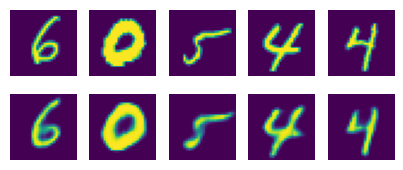

In [10]:
plt.figure(figsize=(7, 2))                         # 출력될 이미지의 크기를 정합니다.


for i, image_idx in enumerate(random_test):       # 랜덤하게 뽑은 이미지를 차례로 나열합니다.
   ax = plt.subplot(2, 7, i + 1)
   plt.imshow(X_test[image_idx].reshape(28, 28))   # 테스트할 이미지를 먼저 그대로 보여줍니다.
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28)) # 오토인코딩 결과를 다음열에 출력합니다.
   ax.axis('off')
plt.show()